# Exercise 1-7

Load the data set for fluid flow past a cylinder (you can either download this from our book
[http://DMDbook.com](http://DMDbook.com) or generate it using the IBPM code on GitHub).
Each column is a flow field that has been reshaped into a vector.

---

**(a)** Compute the SVD of this data set and plot the singular value spectrum and the leading singular vectors.  
The **U** matrix contains eigenflows and the **ΣV\*** represents the amplitudes of these eigenflows as the flow evolves in time.

---

**(b)** Write a code to plot the reconstructed movie for various truncation values *r*.  
Compute the *r* value needed to capture 90%, 99%, and 99.9% of the flow energy based on the singular value spectrum  
(recall that energy is given by the Frobenius norm squared).  
Plot the movies for each of these truncation values and compare the fidelity.  
Also compute the squared Frobenius norm of the error between the true matrix **X** and the reconstructed matrix **X̂**, where **X** is the flow field movie.

---

**(c)** Fix a value *r = 10* and compute the truncated SVD.  
Each column **wₖ ∈ ℝ¹⁰** of the matrix **W = Σ̂V̂\*** represents the mixture of the first 10 eigenflows in the *k*th column of **X**.  
Verify this by comparing the *k*th snapshot of **X** with **Ûwₖ**.

---

**(d)** Now, build a linear regression model for how the amplitudes **wₖ** evolve in time.  
This will be a dynamical system:

**wₖ₊₁ = A wₖ**

Create a matrix **W** with the first 1 through *m – 1* columns of **ΣV\*** and another matrix **W′** with the 2 through *m* columns of **ΣV\***.  
We will now try to solve for a best-fit **A** matrix so that

**W′ ≈ A W**

Compute the SVD of **W** and use this to compute the pseudo-inverse of **W** to solve for **A**.  
Compute the eigenvalues of **A** and plot them in the complex plane.

---

**(e)** Use this **A** matrix to advance the state **wₖ = A^(k–1)w₁** starting from **w₁**.  
Plot the reconstructed flow field using these predicted amplitude vectors and compare with the true values.


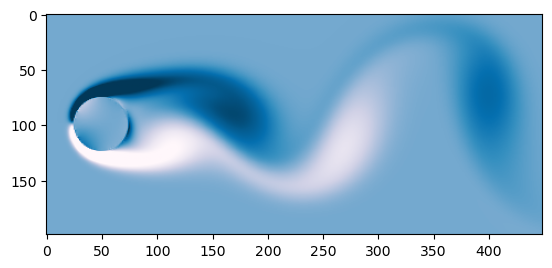

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.io import loadmat
import pandas as pd
import os
data = loadmat(os.path.join("..","data","CYLINDER_ALL.mat"))
X = data['VORTALL']
nx, ny = data['nx'][0][0], data['ny'][0][0]
vmin, vmax = np.percentile(X, 1), np.percentile(X, 99) # Para tener una escala de color consistente, 
                                                       #primera vez que lo uso, antes nose que tan corectas quedaron las graficas
    
plt.imshow(X[:,1].reshape((nx,ny),order='F'),cmap='PuBu', vmin=vmin, vmax=vmax)

Text(0, 0.5, 'Cumulative sum $\\sigma_r$')

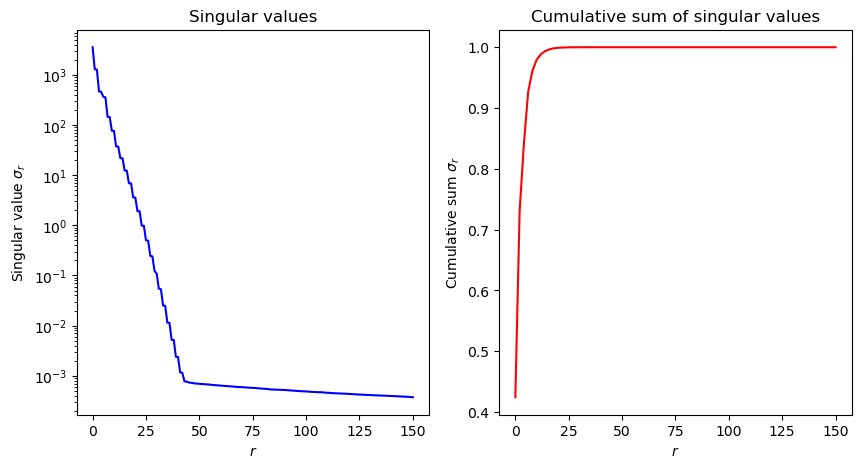

In [4]:
# Grafocar los valores singulares y su suma acumulada 
U, S, Vt = np.linalg.svd(X,full_matrices=False)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].semilogy(S,"b")
ax[0].set_title("Singular values")
ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'Singular value $\sigma_r$')
ax[1].plot(np.cumsum(S)/np.sum(S),"r")
ax[1].set_title("Cumulative sum of singular values")
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'Cumulative sum $\sigma_r$')

### b) Reconstruir el flujo con distintos valores de r

In [5]:
total_energy = np.sum(S**2)
cumulative_energy = np.cumsum(S**2)
rel_energy = cumulative_energy / total_energy
r90 = np.searchsorted(rel_energy, 0.9) + 1
r99 = np.searchsorted(rel_energy, 0.99) + 1
r999 = np.searchsorted(rel_energy, 0.999) + 1
r_values = [2, r90, r99, r999] # Agrego 2 para ver una reconstruccion muy pobre

print(f"r para: 90% {r90}")
print(f"r para: 99% {r99}")
print(f"r para: 99.9% {r999}")

r para: 90% 3
r para: 99% 7
r para: 99.9% 9


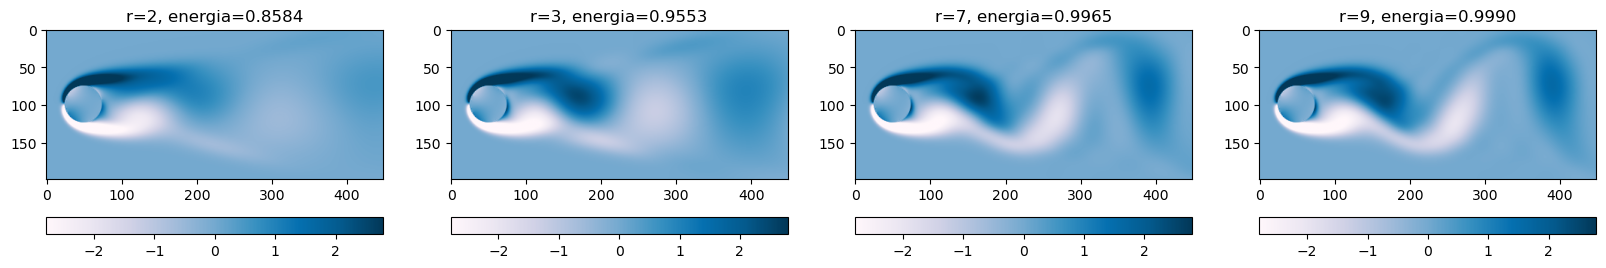

In [6]:
# Reconstruccion estatica
fig, axes = plt.subplots(1,len(r_values), figsize=(20,5))
for ax, r in zip(axes, r_values):
    Xr = U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:]
    snapshot = Xr[:,0].reshape((nx,ny),order='F')
    im = ax.imshow(snapshot,cmap='PuBu', vmin=vmin, vmax=vmax)
    ax.set_title(f"r={r}, energia={rel_energy[r-1]:.4f}")
    fig.colorbar(im, ax=ax,orientation='horizontal',pad=0.1)

In [7]:
# Reconstruccion animada
Xrs = [U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :] for r in r_values]
n_frames = min(Xr.shape[1] for Xr in Xrs) # Para comparar de forma justa las animaciones
fig, axes = plt.subplots(2, 2, figsize=(12, 5),constrained_layout=True)
ims = []
axes_flat = axes.ravel()

for i, (ax, r, Xr) in enumerate(zip(axes_flat, r_values, Xrs)):
    snap0 = Xr[:, 0].reshape((nx, ny), order="F")
    im = ax.imshow(snap0, cmap="PuBu", vmin=vmin, vmax=vmax, animated=True)
    ax.set_title(f"r={r}, energía={rel_energy[r-1]:.4f}")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")
    ims.append(im)

for j in range(len(r_values), len(axes_flat)):
    axes_flat[j].axis("off")

fig.colorbar(ims[0], ax=axes_flat[:len(r_values)].tolist(),
             orientation="horizontal", pad=0.08)

def update(frame):
    for i, im in enumerate(ims):
        snap = Xrs[i][:, frame].reshape((nx, ny), order="F")
        im.set_array(snap)
    return (ims)

ani = FuncAnimation(fig, update, frames=n_frames, interval=100, blit=False)
os.makedirs("generated_visualizations", exist_ok=True)
ani.save("generated_visualizations/comparativa_2x2.gif", writer="pillow", dpi=140)
plt.close(fig)

### Comparativa visual de las cuatro reconstrucciones
![alt text](generated_visualizations/comparativa_2x2.gif)

### c) Comparativa $Uw_k$ vs $X_k$

In [49]:
r = 10
W = np.diag(S[:r]) @ Vt[:r, :]
Ur = U[:, :r]
Xr = Ur @ W
for k in range(r):
    Uwk = Ur @ W[:,k]
    normk = np.linalg.norm(X[:,k] - Uwk)/np.linalg.norm(X[:,k])
    print(f"Norma para k={k}: {normk}")

Norma para k=0: 0.018841675155223937
Norma para k=1: 0.029800805408197257
Norma para k=2: 0.022426108869063755
Norma para k=3: 0.018010188234763354
Norma para k=4: 0.02940745121986522
Norma para k=5: 0.02277642926876956
Norma para k=6: 0.017607699692932348
Norma para k=7: 0.03049914435233077
Norma para k=8: 0.024030194826408217
Norma para k=9: 0.017713320043925822


Es bastante buena la aproximacion con r = 10.

### d) Regresion lineal $w_{k+1} = Aw_k$

In [141]:
Svt = np.diag(S) @ Vt
W1 = Svt[:, :-1] 
W2 = Svt[:, 1:]
# ahora vamos a buscar A / W2 = AW1. Vamos a usar la pseudo inversa de moore-penrose
A = W2 @ np.linalg.pinv(W1)

Text(0.5, 1.0, 'Valores propios de A')

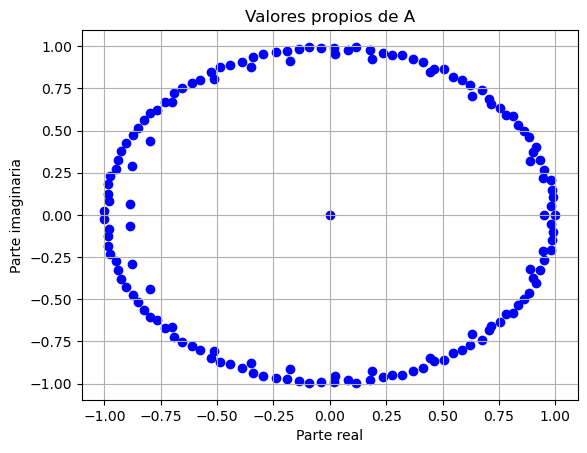

In [142]:
# Vaps de A
vaps, veps = np.linalg.eig(A)
plt.scatter(vaps.real, vaps.imag, color='b')
plt.grid(True)
plt.xlabel("Parte real")
plt.ylabel("Parte imaginaria")
plt.title("Valores propios de A")

wtf, forman un circulo casi perfecto, nose exactamente que implica pero las matrices unitarias tienen vaps en el circulo unitario, este circulo no es unitario pero esta cerca de serlo. Supongo que eso habla que la evolucion del sistema implica algo similar a una roatacion(?).. otra cosa que se me ocurre es que sea algo ciclico que vuelve al estado inicial luego de varios time-steps? porque estos vaps me dan la intuicion de que podria existir un $p: A^p \approx A$, solo que como no es exactamente una rotacion capaz no se cumple. Estaria bueno investigar mas sobre esto.

### e) Usar A para predecir la evolucion del sistema

(89351, 150) (151, 150) (89351, 151)


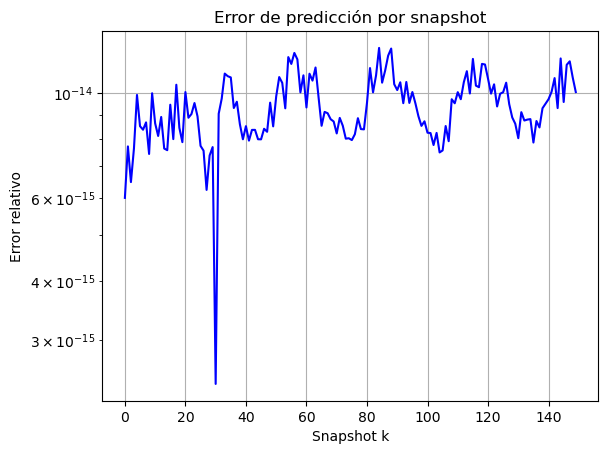

In [150]:
W2_hat = A @ W1
X_hat = U @ W2_hat
print(X_hat.shape, W2_hat.shape,U.shape)
err_k = np.linalg.norm(X[:, 1:] - X_hat, axis=0) / np.linalg.norm(X[:, 1:], axis=0)  #error por snapshot    
plt.semilogy(err_k,'b')
plt.xlabel("Snapshot k")
plt.ylabel("Error relativo")
plt.title("Error de predicción por snapshot")
plt.grid(True)

In [149]:
# gif prediccion vs realidad
n_frames = min(X_hat.shape[1], X.shape[1]-1)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
im1 = axes[0].imshow(X[:, 0].reshape((nx, ny)), cmap="PuBu", vmin=vmin, vmax=vmax)
im2 = axes[1].imshow(X_hat[:, 0].reshape((nx, ny)), cmap="PuBu", vmin=vmin, vmax=vmax)
axes[0].set_title("Real")
axes[1].set_title("Predicción")
axes[0].set_xticks([]); axes[0].set_yticks([]); axes[0].set_aspect("equal")
axes[1].set_xticks([]); axes[1].set_yticks([]); axes[1].set_aspect("equal")
fig.colorbar(im1, ax=axes, orientation="horizontal", pad=0.1)
def update_pred(frame):
    im1.set_array(X[:, frame+1].reshape((nx, ny), order="F"))
    im2.set_array(X_hat[:, frame].reshape((nx, ny), order="F"))
    return (im1, im2)
ani_pred = FuncAnimation(fig, update_pred, frames=n_frames, interval=100, blit=False)
ani_pred.save("generated_visualizations/prediccion_vs_realidad.gif", writer="pillow", dpi=140)
plt.close(fig)

![prediccion_vs_realidad.gif](generated_visualizations/prediccion_vs_realidad.gif)

### Conclusiones
Parece ser bastante buena la prediccion, sobretodo guiandome en el error relativo por snapshot que es bastante bajo. La animacion tambien es indistinguible a simple vista de la real pero no estoy del todo seguro de haber hecho todo bien. Ademas, lo correcto seria haber separado los datos en train y test, y haber entrenado A con train y evaluado con test. No lo hice asi porque no sabia bien como separar los datos, si por tiempo o por espacio (o ambos). Igualmente, la idea hacer regresion lineal sobre las componentes principales y predecir el comportamiento futuro de los datos se logro, no sabre si tiene overfitting pero bueno seguro en la parte de machine learning me voy a centrar mas en esto.